# 1. 前準備

## 1.1. モジュールの読み込み

In [1]:
from keras.models import Sequential
from keras.utils import np_utils, plot_model
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.initializers import glorot_uniform, orthogonal, TruncatedNormal
from keras.callbacks import EarlyStopping
from keras.layers.recurrent import GRU, SimpleRNN

import pandas as pd #行列計算
import numpy as np #行列計算
import math #数値計算
import itertools #順列・組み合わせ

import matplotlib.pyplot as plt #グラフ
import seaborn as sns

from datetime import datetime, timedelta
import mpl_finance as mpf
import talib as ta # テクニカル指標

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.ensemble import RandomForestRegressor, VotingClassifier

# GBDT
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
#from catboost import CatBoostClassifier, Pool

# フォント
import matplotlib.font_manager as fm
from matplotlib import rcParams

Using TensorFlow backend.


## 1.2. グラフのフォントの設定

In [2]:
fm.findSystemFonts()
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']

# 2. データの準備

## 2.1. データの読み込み

In [3]:
df = pd.read_csv('doll_price_regression_analysis.csv')

## 2.2. データの確認

In [4]:
df

,id,creator,price,date,time,type,hair_style,hair_color,hair_accessory,braid,...,pupil,eyes_bags,clothes,clothes_color,mouth_close,mouth_size,yaeba,tongue,background,background_color
0,5,SakuraHolic,4000,2019-05-26,21:19,ddh-01,short,red,1,0,...,oval,0,sailor_school_uniform,red,1,L,0,0,nothing,nothing
1,6,クラナル,41100,2019-05-26,21:23,ddh-01,twin_tail,pink,1,0,...,dot,0,dress,white,0,L,1,1,set,white
2,7,CPW,40500,2019-05-26,21:35,ddh-01,long,brown,1,0,...,oval,0,sailor_school_uniform,white,1,M,0,0,set,pink
3,8,Miel_Magical,26500,2019-05-26,22:06,ddh-01,medium,silver,1,0,...,line,0,dress,black,0,S,0,0,wall,blue
4,9,cocoa*milk,9000,2019-05-26,22:09,ddh-01,medium,silver,0,0,...,dot,0,casual,beige,1,M,1,0,set,ambiguous
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,131,にゃんこ工房,30000,2019-06-17,23:54,ddh-01,long,brown,1,0,...,oval,0,casual,white,1,M,1,0,set,beige
127,132,にゃんこ工房,36800,2019-06-18,13:24,ddh-01,long,white,1,0,...,diamond,0,casual,beige,1,M,0,0,set,beige
128,133,R@BIT,11000,2019-06-18,21:55,ddh-01,long,black,0,0,...,dot,0,dress,white,1,M,0,0,room,white
129,134,Yue,36500,2019-06-18,22:34,ddh-01,long,purple,1,0,...,diamond,0,dress,light_blue,1,M,0,0,wall,white


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 21 columns):
id                  131 non-null int64
creator             131 non-null object
price               131 non-null int64
date                131 non-null object
time                131 non-null object
type                131 non-null object
hair_style          131 non-null object
hair_color          131 non-null object
hair_accessory      131 non-null int64
braid               131 non-null int64
eyes_color          131 non-null object
pupil               131 non-null object
eyes_bags           131 non-null int64
clothes             131 non-null object
clothes_color       131 non-null object
mouth_close         131 non-null int64
mouth_size          131 non-null object
yaeba               131 non-null int64
tongue              131 non-null int64
background          131 non-null object
background_color    131 non-null object
dtypes: int64(8), object(13)
memory usage: 21.6+ KB


## 2.3. データの加工

In [6]:
import datetime

str1 = []
for i in df['date']:
    #print(i)
    s = datetime.datetime.strptime(i, '%Y-%m-%d').strftime('%A')
    #print(s)
    str1.append(s)
    
str2 = []
for i in df['time']:
    #print(i)
    s = int(i[-5:-3]) #datetime.datetime.strptime(i[0:10], '%Y-%m-%d').strftime('%A'
    #print(s)
    str2.append(s)
    
s1 = pd.Series(str1)
s2 = pd.Series(str2)
df_1 = pd.DataFrame(s1, columns=['week'])
df_2 = pd.DataFrame(s2, columns=['hour'])
df = df.join(df_1)
df = df.join(df_2)

In [7]:
df

,id,creator,price,date,time,type,hair_style,hair_color,hair_accessory,braid,...,clothes,clothes_color,mouth_close,mouth_size,yaeba,tongue,background,background_color,week,hour
0,5,SakuraHolic,4000,2019-05-26,21:19,ddh-01,short,red,1,0,...,sailor_school_uniform,red,1,L,0,0,nothing,nothing,Sunday,21
1,6,クラナル,41100,2019-05-26,21:23,ddh-01,twin_tail,pink,1,0,...,dress,white,0,L,1,1,set,white,Sunday,21
2,7,CPW,40500,2019-05-26,21:35,ddh-01,long,brown,1,0,...,sailor_school_uniform,white,1,M,0,0,set,pink,Sunday,21
3,8,Miel_Magical,26500,2019-05-26,22:06,ddh-01,medium,silver,1,0,...,dress,black,0,S,0,0,wall,blue,Sunday,22
4,9,cocoa*milk,9000,2019-05-26,22:09,ddh-01,medium,silver,0,0,...,casual,beige,1,M,1,0,set,ambiguous,Sunday,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,131,にゃんこ工房,30000,2019-06-17,23:54,ddh-01,long,brown,1,0,...,casual,white,1,M,1,0,set,beige,Monday,23
127,132,にゃんこ工房,36800,2019-06-18,13:24,ddh-01,long,white,1,0,...,casual,beige,1,M,0,0,set,beige,Tuesday,13
128,133,R@BIT,11000,2019-06-18,21:55,ddh-01,long,black,0,0,...,dress,white,1,M,0,0,room,white,Tuesday,21
129,134,Yue,36500,2019-06-18,22:34,ddh-01,long,purple,1,0,...,dress,light_blue,1,M,0,0,wall,white,Tuesday,22


## 2.4. 外れ値を除く

In [8]:
Q1 = df['price'].quantile(.25)
Q3 = df['price'].quantile(.75) 

IQR = Q3 - Q1
threshold = Q3 + 1.5 * IQR

df = df[~df['price'].apply(lambda x:x > threshold)]

In [9]:
df

,id,creator,price,date,time,type,hair_style,hair_color,hair_accessory,braid,...,clothes,clothes_color,mouth_close,mouth_size,yaeba,tongue,background,background_color,week,hour
0,5,SakuraHolic,4000,2019-05-26,21:19,ddh-01,short,red,1,0,...,sailor_school_uniform,red,1,L,0,0,nothing,nothing,Sunday,21
1,6,クラナル,41100,2019-05-26,21:23,ddh-01,twin_tail,pink,1,0,...,dress,white,0,L,1,1,set,white,Sunday,21
2,7,CPW,40500,2019-05-26,21:35,ddh-01,long,brown,1,0,...,sailor_school_uniform,white,1,M,0,0,set,pink,Sunday,21
3,8,Miel_Magical,26500,2019-05-26,22:06,ddh-01,medium,silver,1,0,...,dress,black,0,S,0,0,wall,blue,Sunday,22
4,9,cocoa*milk,9000,2019-05-26,22:09,ddh-01,medium,silver,0,0,...,casual,beige,1,M,1,0,set,ambiguous,Sunday,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,131,にゃんこ工房,30000,2019-06-17,23:54,ddh-01,long,brown,1,0,...,casual,white,1,M,1,0,set,beige,Monday,23
127,132,にゃんこ工房,36800,2019-06-18,13:24,ddh-01,long,white,1,0,...,casual,beige,1,M,0,0,set,beige,Tuesday,13
128,133,R@BIT,11000,2019-06-18,21:55,ddh-01,long,black,0,0,...,dress,white,1,M,0,0,room,white,Tuesday,21
129,134,Yue,36500,2019-06-18,22:34,ddh-01,long,purple,1,0,...,dress,light_blue,1,M,0,0,wall,white,Tuesday,22


# 3. データの分析

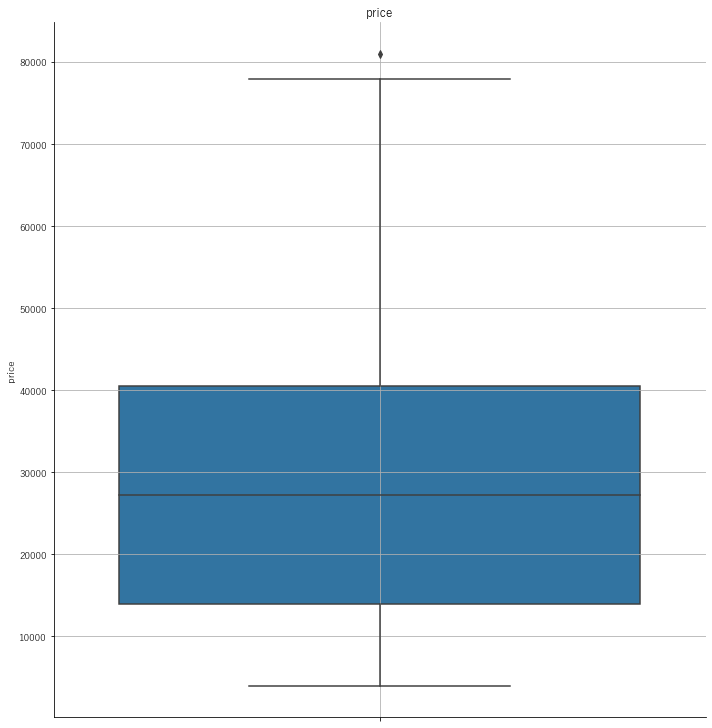

In [10]:
col_name = 'price'

sns.catplot(y="price", kind="box", data=df, height=10, aspect=1);
plt.title(col_name)
plt.grid()

#g = sns.catplot(x='price', y=col_name, data=df, height=10, aspect=1)
#plt.title(col_name)
#plt.grid()
#g.set_xticklabels(rotation=0) # X軸ラベルバグ発生

## 3.1. 作者

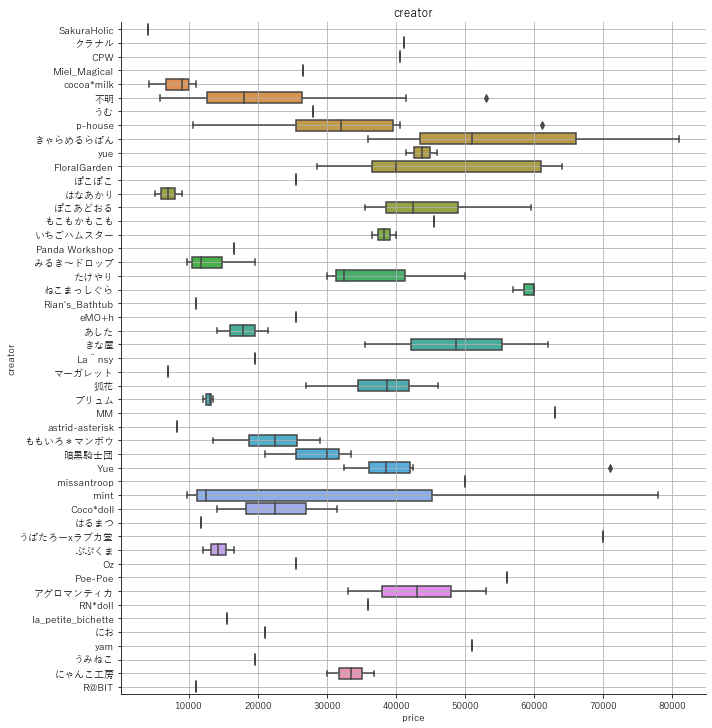

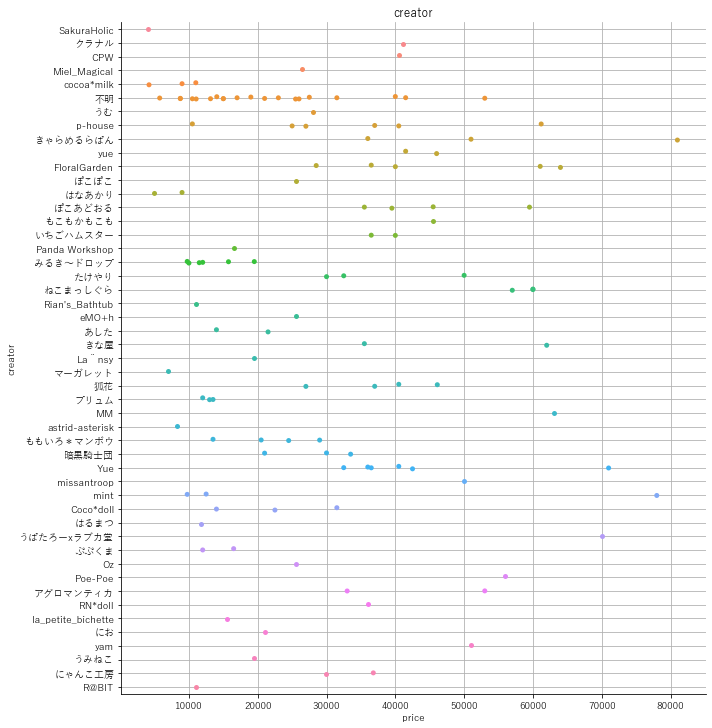

In [11]:
col_name = 'creator'

sns.catplot(x="price", y=col_name, kind="box", data=df, height=10, aspect=1);
plt.title(col_name)
plt.grid()

g = sns.catplot(x='price', y=col_name, data=df, height=10, aspect=1)
plt.title(col_name)
plt.grid()
#g.set_xticklabels(rotation=0) # X軸ラベルバグ発生

## 3.2. 髪

### 3.2.1. 髪型

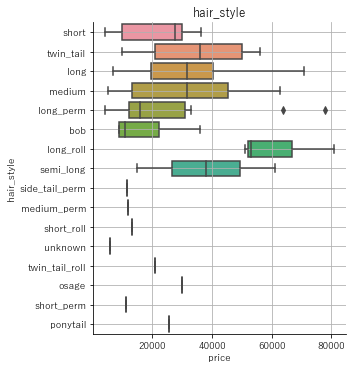

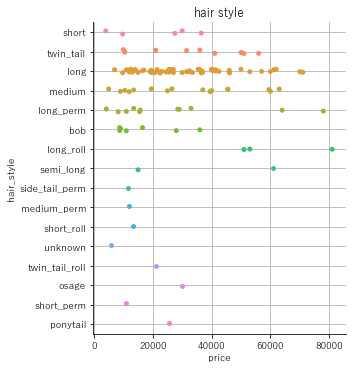

In [12]:
col_name = 'hair_style'

sns.catplot(x="price", y=col_name, kind="box", data=df);
plt.title(col_name)
plt.grid()

g = sns.catplot(x='price', y=col_name, data=df)
plt.title('hair style')
plt.grid()
#g.set_xticklabels(rotation=0) # X軸ラベルバグ発生

### 3.2.2. 髪の色

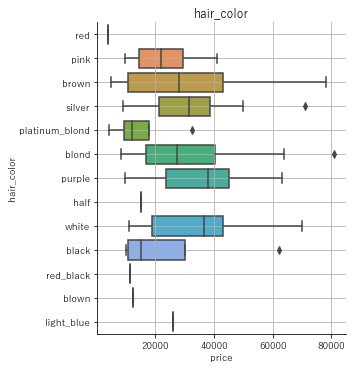

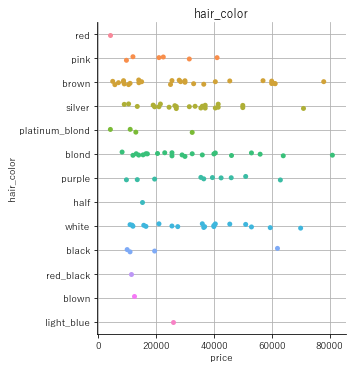

In [13]:
col_name = 'hair_color'

#ig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
#x1.grid()
#x2.grid()

sns.catplot(x="price", y=col_name, kind="box", data=df)#, ax=ax);
plt.title(col_name)
plt.grid()

g = sns.catplot(x='price', y=col_name, data=df)#, ax=ax2)
plt.title(col_name)
plt.grid()
#g.set_xticklabels(rotation=0) # X軸ラベルバグ発生

### 3.2.3. 髪のアクセサリーの有無

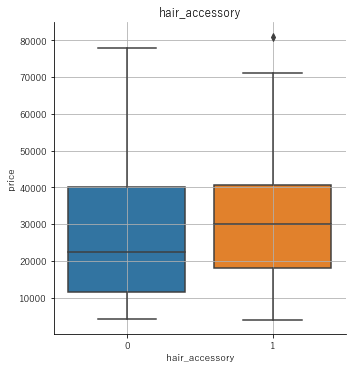

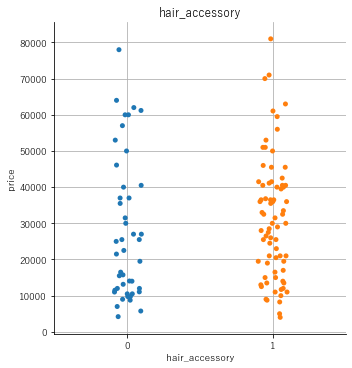

In [14]:
col_name = 'hair_accessory'

sns.catplot(x=col_name, y="price", kind="box", data=df);
plt.title(col_name)
plt.grid()

g = sns.catplot(x=col_name, y='price', data=df)
plt.title(col_name)
plt.grid()
#g.set_xticklabels(rotation=0) # X軸ラベルバグ発生

### 3.2.4. 三編み

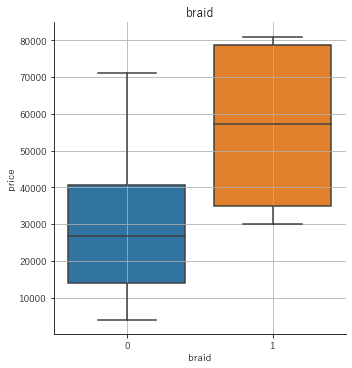

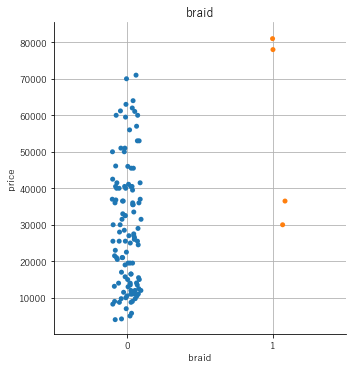

In [15]:
col_name = 'braid'

sns.catplot(x=col_name, y="price", kind="box", data=df);
plt.title(col_name)
plt.grid()

g = sns.catplot(x=col_name, y='price', data=df)
plt.title(col_name)
plt.grid()
#g.set_xticklabels(rotation=0) # X軸ラベルバグ発生

## 目

### 目の色

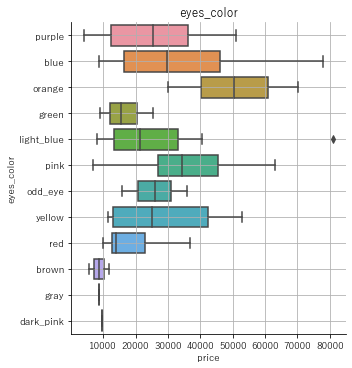

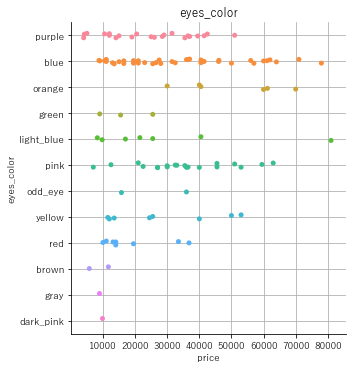

In [16]:
col_name = 'eyes_color'

sns.catplot(x="price", y=col_name, kind="box", data=df);
plt.title(col_name)
plt.grid()

g = sns.catplot(x='price', y=col_name, data=df)
plt.title(col_name)
plt.grid()
#g.set_xticklabels(rotation=0) # X軸ラベルバグ発生

### 瞳の形

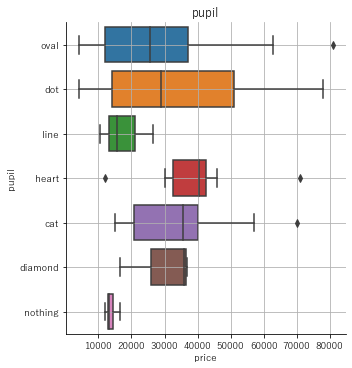

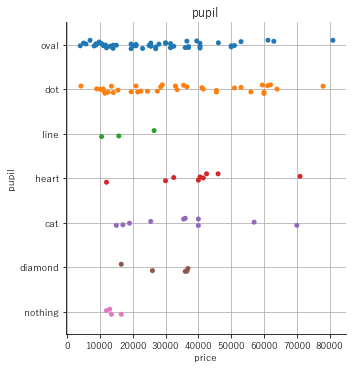

In [17]:
col_name = 'pupil'

sns.catplot(x="price", y=col_name, kind="box", data=df);
plt.title(col_name)
plt.grid()

g = sns.catplot(x='price', y=col_name, data=df)
plt.title(col_name)
plt.grid()
#g.set_xticklabels(rotation=0) # X軸ラベルバグ発生

## 服

### 服の種類

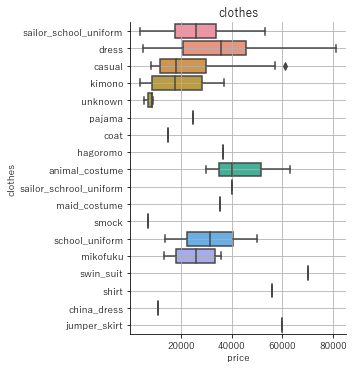

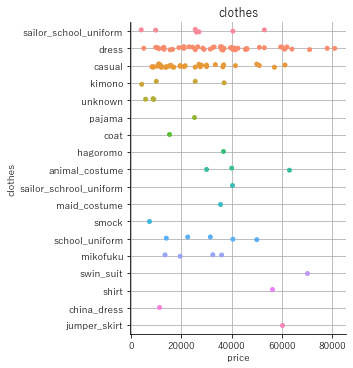

In [18]:
col_name = 'clothes'

sns.catplot(x="price", y=col_name, kind="box", data=df);
plt.title(col_name)
plt.grid()

g = sns.catplot(x='price', y=col_name, data=df)
plt.title(col_name)
plt.grid()
#g.set_xticklabels(rotation=0) # X軸ラベルバグ発生

### 服の色

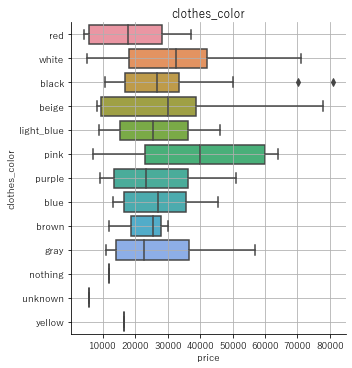

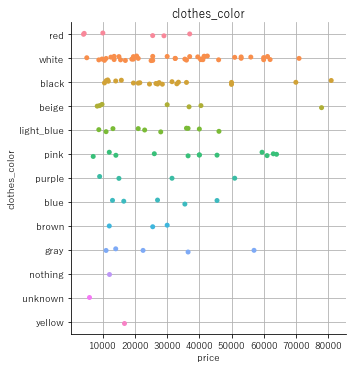

In [19]:
col_name = 'clothes_color'

sns.catplot(x="price", y=col_name, kind="box", data=df);
plt.title(col_name)
plt.grid()

g = sns.catplot(x='price', y=col_name, data=df)
plt.title(col_name)
plt.grid()
#g.set_xticklabels(rotation=0) # X軸ラベルバグ発生

## 背景

### 背景のタイプ

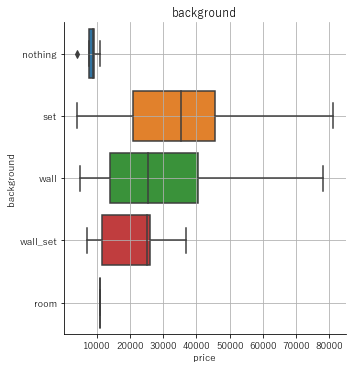

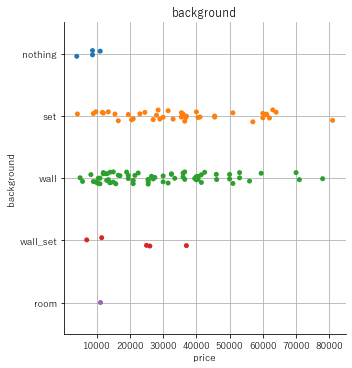

In [20]:
col_name = 'background'

sns.catplot(x="price", y=col_name, kind="box", data=df);
plt.title(col_name)
plt.grid()

g = sns.catplot(x='price', y=col_name, data=df)
plt.title(col_name)
plt.grid()
#g.set_xticklabels(rotation=0) # X軸ラベルバグ発生

### 背景の色

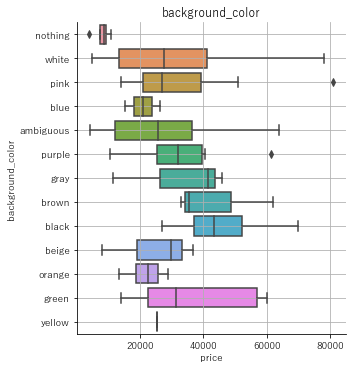

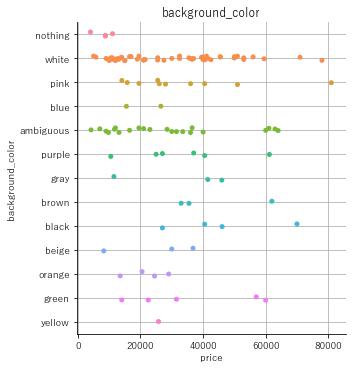

In [21]:
col_name = 'background_color'

sns.catplot(x="price", y=col_name, kind="box", data=df);
plt.title(col_name)
plt.grid()

g = sns.catplot(x='price', y=col_name, data=df)
plt.title(col_name)
plt.grid()
#g.set_xticklabels(rotation=0) # X軸ラベルバグ発生

## 時間

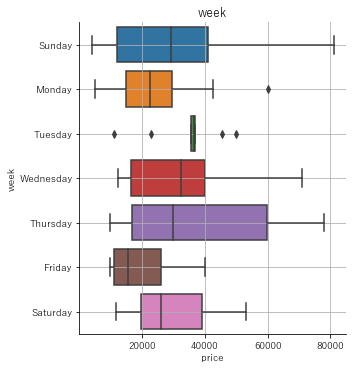

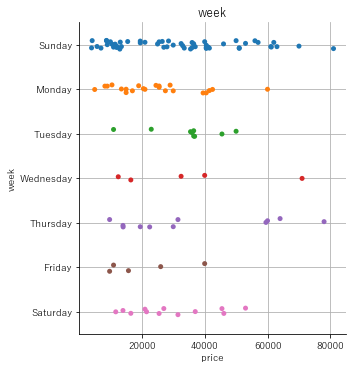

In [22]:
col_name = 'week'

sns.catplot(x="price", y=col_name, kind="box", data=df);
plt.title(col_name)
plt.grid()

g = sns.catplot(x='price', y=col_name, data=df)
plt.title(col_name)
plt.grid()
#g.set_xticklabels(rotation=0) # X軸ラベルバグ発生

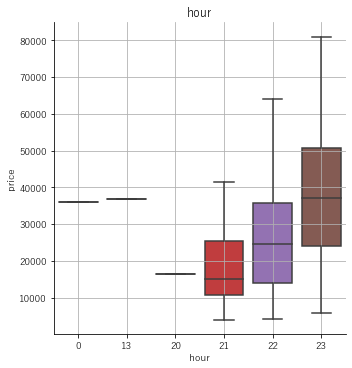

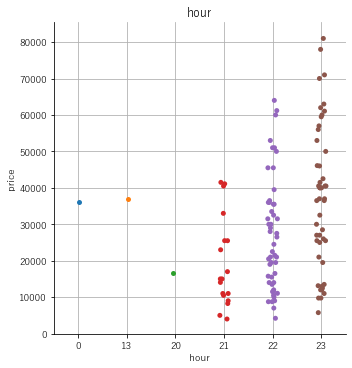

In [23]:
col_name = 'hour'

sns.catplot(x=col_name, y="price", kind="box", data=df);
plt.title(col_name)
plt.grid()

g = sns.catplot(x=col_name, y='price', data=df)
plt.title(col_name)
plt.grid()
#g.set_xticklabels(rotation=0) # X軸ラベルバグ発生

## 口

### 口を閉じているか

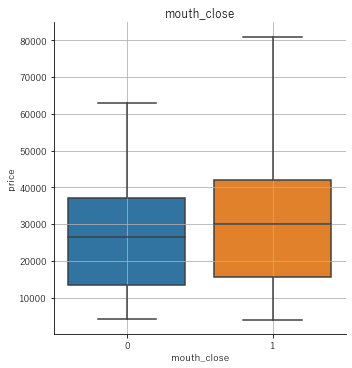

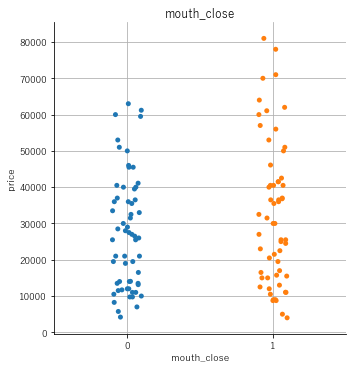

In [24]:
col_name = 'mouth_close'

sns.catplot(x=col_name, y="price", kind="box", data=df);
plt.title(col_name)
plt.grid()

g = sns.catplot(x=col_name, y='price', data=df)
plt.title(col_name)
plt.grid()
#g.set_xticklabels(rotation=0) # X軸ラベルバグ発生

### 口のサイズ

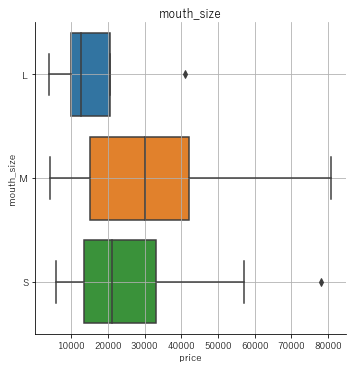

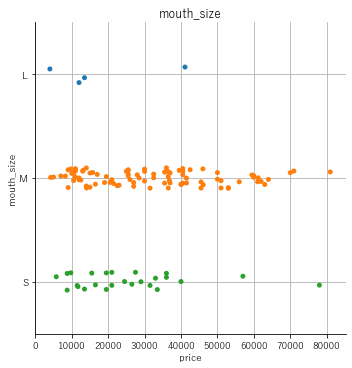

In [25]:
col_name = 'mouth_size'

sns.catplot(x="price", y=col_name, kind="box", data=df);
plt.title(col_name)
plt.grid()

g = sns.catplot(x='price', y=col_name, data=df)
plt.title(col_name)
plt.grid()
#g.set_xticklabels(rotation=0) # X軸ラベルバグ発生

### 八重歯の有無

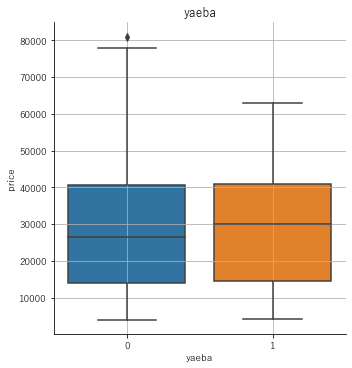

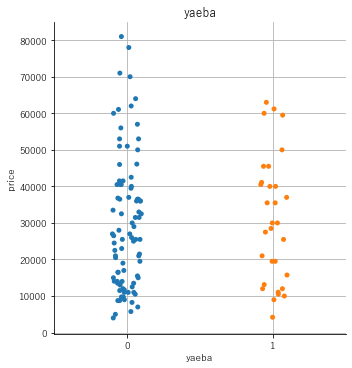

In [26]:
col_name = 'yaeba'

sns.catplot(x=col_name, y="price", kind="box", data=df);
plt.title(col_name)
plt.grid()

g = sns.catplot(x=col_name, y='price', data=df)
plt.title(col_name)
plt.grid()
#g.set_xticklabels(rotation=0) # X軸ラベルバグ発生

### 立体的な舌の有無

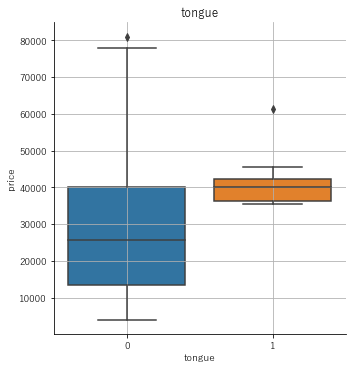

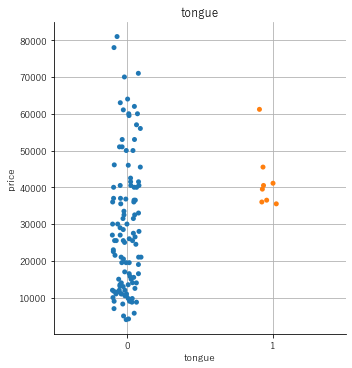

In [27]:
col_name = 'tongue'

sns.catplot(x=col_name, y="price", kind="box", data=df);
plt.title(col_name)
plt.grid()

g = sns.catplot(x=col_name, y='price', data=df)
plt.title(col_name)
plt.grid()
#g.set_xticklabels(rotation=0) # X軸ラベルバグ発生

# 学習

In [28]:
df = df.drop(['id', 'creator', 'date', 'time', 'type'], axis=1)

In [29]:
from sklearn.preprocessing import LabelEncoder

for column in df.select_dtypes(include=object).columns.values.tolist():
    le = LabelEncoder()
    le.fit(df[column])
    df[column] = le.transform(df[column])

In [30]:
X = df.drop('price', axis=1).values
y = df['price'].values

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    shuffle=True,
    random_state=0
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    shuffle=True,
    random_state=0
)

In [31]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(76, 17)
(20, 17)
(24, 17)
(76,)
(20,)
(24,)


In [32]:
def lightgbm_clf(X_train, y_train, X_test, y_test):
    estimator = LGBMRegressor()
    
    """
    # 検証するパラメータ
    param_grid = {
        'max_leaves': [0, 1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
        #'n_estimators': [4, 8, 16, 32], # ★
        'num_leaves': [31, 15, 7, 3, 63], # ★★★
        #'num_leaves': [8, 16, 32, 64],
        'min_data_in_leaf': [0, 5, 15, 100, 200, 300], # ★★
        #'min_data_in_leaf': [0, 2],
        #'max_depth':  [4, 8], # ★★
        #'verbose': [0],
    }"""
    
    # 検証するパラメータ
    param_grid = {
        'n_estimators': [10000], # 一つだけ大きめの値を入れる
        'max_depth': [1, 2, 3, 4, 5, 6, 7],# データが少ないときは過学習を防ぐため小さくする。
        'num_leaves': [7, 8, 9, 10, 11, 12],# 木にある分岐の数。大きくすると過学習を起こす。
        #'min_data_in_leaf': [0, 5, 15, 100, 200, 300],
        'verbose': [0],# 学習中のメッセージの量
    }
    
    # グリッドサーチ
    gscv = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        cv=3,
        n_jobs=-1,
        verbose=0,
        return_train_score=False
    )
    gscv.fit(X_train, y_train, early_stopping_rounds=100, eval_set=[[X_test, y_test]])
    
    # 最も良いモデルを返す
    print('LightGBM is finished!')
    print(gscv.best_params_)
    return gscv.best_estimator_

In [33]:
from sklearn.metrics import mean_squared_error

models = {
    #'RandomForest': random_forest_clf(_X_train, _y_train),
    #'XGBoost': xgboost_clf(_X_train, _y_train, _X_test, _y_test),
    'LightGBM': lightgbm_clf(X_train, y_train, X_valid, y_valid),
    #'CatBoost': catboost_clf(_X_train, _y_train, _X_test, _y_test),
}

for name, model in zip(models.keys(), models.values()):
    # 正解率を表示する方法1
    #print(name, model.score(X_valid, y_valid)) # 正解率を出す
    
    # 正解率を表示する方法2
    pred = model.predict(X_valid) # 予測を出す(0と1の１次元配列)
    print(np.sqrt(mean_squared_error(y_valid, pred)))
    
    #print(pred)
    #print(name, accuracy_score(_y_test, pred)) # 正解率を出す

[1]	valid_0's l2: 3.88246e+08
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's l2: 3.83149e+08
[3]	valid_0's l2: 3.84085e+08
[4]	valid_0's l2: 3.83529e+08
[5]	valid_0's l2: 3.79513e+08
[6]	valid_0's l2: 3.82094e+08
[7]	valid_0's l2: 3.8317e+08
[8]	valid_0's l2: 3.82751e+08
[9]	valid_0's l2: 3.79442e+08
[10]	valid_0's l2: 3.77612e+08
[11]	valid_0's l2: 3.80058e+08
[12]	valid_0's l2: 3.81171e+08
[13]	valid_0's l2: 3.8091e+08
[14]	valid_0's l2: 3.78216e+08
[15]	valid_0's l2: 3.7688e+08
[16]	valid_0's l2: 3.79189e+08
[17]	valid_0's l2: 3.79146e+08
[18]	valid_0's l2: 3.78167e+08
[19]	valid_0's l2: 3.80478e+08
[20]	valid_0's l2: 3.84137e+08
[21]	valid_0's l2: 3.81769e+08
[22]	valid_0's l2: 3.82698e+08
[23]	valid_0's l2: 3.84895e+08
[24]	valid_0's l2: 3.84241e+08
[25]	valid_0's l2: 3.84241e+08
[26]	valid_0's l2: 3.82283e+08
[27]	valid_0's l2: 3.84894e+08
[28]	valid_0's l2: 3.86943e+08
[29]	valid_0's l2: 3.86527e+08
[30]	valid_0's l2: 3.8657e+08
[31]	valid_0's l2: 3

C:\Users\15rd112\AppData\Local\Continuum\anaconda3\envs\python3.6\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### 予測

In [34]:
#models = models['RandomForest'] # 使用するモデル
#models = models['XGBoost'] # 使用するモデル
moels = models['LightGBM'] # 使用するモデル
pred = model.predict(X_test) # 本番のテストデータを予測

df_pred = pd.DataFrame([pred, y_test])
df_pred = df_pred.T

df_pred

,0,1
0,32931.035913,53000.0
1,24168.766398,53000.0
2,28165.004857,46100.0
3,32931.035913,37000.0
4,30571.388677,11000.0
5,26073.882835,19500.0
6,26073.882835,28000.0
7,35613.624222,41500.0
8,31294.444689,12000.0
9,32931.035913,9750.0


In [35]:
print('MAE', abs(pred - y_test).sum() / y_test.size)
print('RMSE', np.sqrt(((pred - y_test)**2).sum() / y_test.size))

MAE 12263.952153311897
RMSE 14887.717202382471
